In [1]:
import mab.Environment_non_stationary
import mab.Environment
import mab.Shop
from mab.ucb_learner import *
from mab.utilities import *

In [2]:
shop_ts = Shop.Shop()
shop_c = Shop.Shop()

env = Environment_non_stationary.Environment(shop_ts.prices1, shop_ts.prices2, shop_ts.discounts, n_phases=4)
s_env = Environment.Environment(shop_ts.prices1,shop_ts.prices2,shop_ts.discounts)



In [3]:
price_arms = [(i, j) for i in range(len(shop_ts.prices1)) for j in range(len(shop_ts.prices2))]
n_price_arms = len(price_arms)

matching_arms = [(i, j, k, l) for i in range(len(shop_ts.prices1)) for j in range(len(shop_ts.prices2)) for k in range(shop_ts.n_classes) for l in range(len(shop_ts.discounts))]
n_matching_arms = len(matching_arms)

##2-STEP ts

shop_ts.set_price_learner('TS', n_price_arms)
shop_ts.set_assignment_learner('TS', n_matching_arms)

## SLIDING WINDOW TS
days=365
frame_size = int(days / env.n_phases)

shop_ts.set_price_learner_sw('TS', n_price_arms, frame_size=frame_size, days=days)
shop_ts.set_assignment_learner_sw('TS', n_matching_arms, frame_size=frame_size, days=days)


## Stationary Environment Experiment
We want to do a comparison between two shop: one with simple TS and the other one with TS Sliding Window (do not make sense to compare also TS Change Detector because in the stationary environment is equal to simple TS).


We expect a higher revenue from simple TS.


In [4]:
print(shop_ts.price_learner_sw.frame_size)

91


In [5]:
##GET CLAIRVOYANT PRICE
generated_promo_ratios = np.array([0.4, 0.25, 0.2, 0.15])
max_ind_reward = max(s_env.prices1) + max(s_env.prices2)

shop_c.set_conv_rate(s_env.true_conv1,s_env.true_conv2)
expected_rewards = np.zeros((5,5)) # price1*price2
shop_c.set_expected_customers(np.array([25, 25, 25, 25]))
customers_mean = np.array([25, 25, 25, 25])

##### other way to calculate clairvoyant
cec = shop_c.get_customer_list()
cep = shop_c.get_promo_list(generated_promo_ratios)

cmt, cpa, cer, ers  = shop_c.get_clairvoyant_prices_and_matching(cec, cep, 5, 5)
cp1idx = price_arms[cpa][0]
cp2idx = price_arms[cpa][1]
cp1 = s_env.prices1[cp1idx]
cp2 = s_env.prices2[cp2idx]

cpf = shop_c.get_promo_fractions_from_tuples(cmt)

print(cpf)
print(cp1)
print(cp2)
print(cer)

[[1.  0.  0.  0. ]
 [0.  0.2 0.8 0. ]
 [0.  0.8 0.  0.2]
 [0.6 0.  0.  0.4]]
200.0
300.0
18377.091994077367


In [6]:
days = 365


ts_rewards_per_class_per_day = []
ts_sw_rewards_per_class_per_day = []
c_rewards_per_class_per_day = []

customers_em = np.array([0, 0, 0, 0])
customers_ie = np.array([25, 25, 25, 25])

for day in range(days):
    if day == 0:
        shop_ts.set_expected_customers(customers_ie)
        
    else:
        customers_em = (customers_em*(day-1) + s_env.customers) / day
        shop_ts.set_expected_customers((customers_em + 0.99).astype(int))
    
    # select the price for 2 step learner with no sliding window
    chosen_price_tuple_idx_ts = shop_ts.price_learner.pull_arm()

    price1idx_ts = price_arms[chosen_price_tuple_idx_ts][0]
    price2idx_ts = price_arms[chosen_price_tuple_idx_ts][1]
    price1_ts = s_env.prices1[price_arms[chosen_price_tuple_idx_ts][0]]
    price2_ts = s_env.prices2[price_arms[chosen_price_tuple_idx_ts][1]]

    # perform matching and get promo fractions for 2 step learner with no sliding window 
    expected_customers_ts = shop_ts.get_customer_list()
    expected_promos_ts = shop_ts.get_promo_list(generated_promo_ratios)
    matched_tuples_ts = shop_ts.assignment_learner.pull_arm_matching(expected_customers_ts, expected_promos_ts, matching_arms, price1idx_ts, price2idx_ts)
    promo_fractions_ts = shop_ts.get_promo_fractions_from_tuples(matched_tuples_ts)

    # perform matching and get promo fractions for learner with sliding window
    price_arm_idx_ts_sw = shop_ts.price_learner_sw.pull_arm(day)

    price1idx_ts_sw = price_arms[price_arm_idx_ts_sw][0]
    price2idx_ts_sw = price_arms[price_arm_idx_ts_sw][1]
    price1_ts_sw = s_env.prices1[price_arms[price_arm_idx_ts_sw][0]]
    price2_ts_sw = s_env.prices2[price_arms[price_arm_idx_ts_sw][1]]

    expected_customers_ts_sw = shop_ts.get_customer_list()
    expected_promos_ts_sw = shop_ts.get_promo_list(generated_promo_ratios)
    matched_tuples_ts_sw = shop_ts.assignment_learner_sw.pull_arm_matching(expected_customers_ts_sw, expected_promos_ts_sw, matching_arms, day, price1idx_ts_sw, price2idx_ts_sw)
    promo_fractions_ts_sw = shop_ts.get_promo_fractions_from_tuples(matched_tuples_ts_sw)

    # simulate the day
    s_env.generate_next_day_customers()

    enum_customers = list(enumerate(s_env.customers))
    customers = np.concatenate([np.ones(c).astype(int)*p for p,c in enum_customers])
    np.random.shuffle(customers)

    revenue_ts = []
    revenue_ts_sw = []
    revenue_c = []

    ts_total_reward = 0
    ts_sw_total_reward = 0
    c_total_reward = 0

    c_count = 0

    for cust in customers:
        ts_ind_reward = 0
        ts_sw_ind_reward = 0

        
        selected_promo_ts = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_ts[cust])
        selected_promo_ts_sw = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_ts_sw[cust])
        selected_promo_c = np.random.choice([0, 1, 2, 3], 1, p=cpf[cust])

        

        ts_buy1 = s_env.round1(cust, price1_ts)
        ts_buy2 = 0
        if ts_buy1:
            ts_buy2 = s_env.round2(cust, selected_promo_ts, price2_ts)

        
        ts_sw_buy1 = s_env.round1(cust, price1_ts_sw)
        ts_sw_buy2 = 0
        if ts_sw_buy1:
            ts_sw_buy2 = s_env.round2(cust, selected_promo_ts_sw, price2_ts_sw)

        ts_ind_reward = ts_buy1*price1_ts + ts_buy2*price2_ts*(1-shop_ts.discounts[selected_promo_ts])
        ts_sw_ind_reward = ts_sw_buy1*price1_ts_sw + ts_sw_buy2*price2_ts_sw*(1-shop_ts.discounts[selected_promo_ts_sw])
                
        c_ind_reward = s_env.true_conv1[cust, cp1idx]*cp1 + s_env.true_conv1[cust, cp1idx]*s_env.true_conv2[selected_promo_c, cust, cp2idx]*cp2*(1-shop_ts.discounts[selected_promo_c])

        
        norm_ts_ind_reward = ts_ind_reward / max_ind_reward
        norm_ts_sw_reward = ts_sw_ind_reward / max_ind_reward

        # update 2-step ts
        shop_ts.price_learner.update(chosen_price_tuple_idx_ts, norm_ts_ind_reward)
        matching_arm_index_ts = matching_arms.index((price1idx_ts, price2idx_ts, cust, selected_promo_ts))
        shop_ts.assignment_learner.update(matching_arm_index_ts, norm_ts_ind_reward)

        shop_ts.price_learner_sw.update(price_arm_idx_ts_sw, norm_ts_sw_reward,day)
        matching_arm_index_ts_sw = matching_arms.index((price1idx_ts_sw, price2idx_ts_sw ,cust,selected_promo_ts_sw))
        shop_ts.assignment_learner_sw.update(matching_arm_index_ts_sw,norm_ts_sw_reward,day)
        
        revenue_ts.append(ts_ind_reward)
        revenue_ts_sw.append(ts_sw_ind_reward)
        revenue_c.append(c_ind_reward)

    ts_rewards_per_class_per_day.append(np.mean(revenue_ts))
    ts_sw_rewards_per_class_per_day.append(np.mean(revenue_ts_sw))
    c_rewards_per_class_per_day.append(np.mean(revenue_c))

The theory is confirmed, simple TS works slightly better then TS Sliding Window

Text(0, 0.5, 'Revenue')

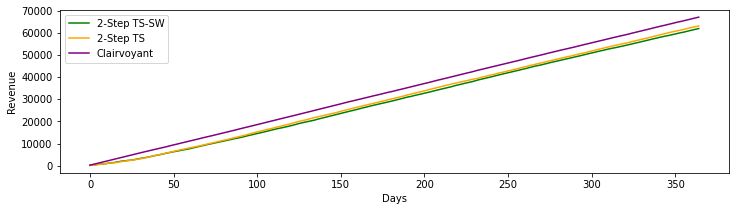

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,3))
plt.plot(np.cumsum(ts_sw_rewards_per_class_per_day), color='green', label='2-Step TS-SW')
plt.plot(np.cumsum(ts_rewards_per_class_per_day), color='orange', label='2-Step TS')
plt.plot(np.cumsum(c_rewards_per_class_per_day), color='purple', label='Clairvoyant')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Revenue')

Text(0, 0.5, 'Revenue')

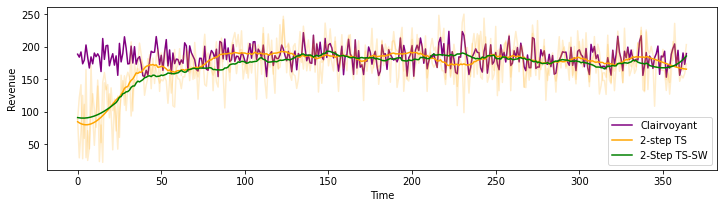

In [8]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

plt.figure(figsize=(12,3))
plt.plot(c_rewards_per_class_per_day, color='purple',label='Clairvoyant')
plt.plot(ts_rewards_per_class_per_day, color='orange', alpha=0.2)
plt.plot(savgol_filter(ts_rewards_per_class_per_day, 45, 3), color='orange', label='2-step TS')
plt.plot(ts_sw_rewards_per_class_per_day, color='orange', alpha=0.2)
plt.plot(savgol_filter(ts_sw_rewards_per_class_per_day, 45, 3), color='green', label='2-Step TS-SW')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Revenue')

Text(0, 0.5, 'Regret')

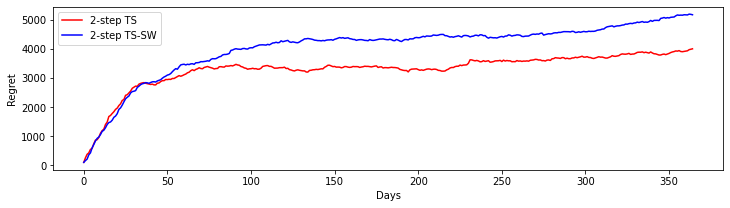

In [9]:
plt.figure(figsize=(12,3))
plt.plot(np.cumsum(np.array(c_rewards_per_class_per_day) - np.array(ts_rewards_per_class_per_day)), color='red', label='2-step TS')
plt.plot(np.cumsum(np.array(c_rewards_per_class_per_day) - np.array(ts_sw_rewards_per_class_per_day)), color='blue', label='2-step TS-SW')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Regret')

## Non stationary environment
In this case make sense to test also the shop with TS Change Detector

In [10]:
generated_promo_ratios = np.array([0.4, 0.25, 0.2, 0.15])
max_ind_reward = max(env.prices1) + max(env.prices2)

In [11]:
cr11 = np.array([[0.60, 0.51, 0.28, 0.23, 0.19],
       [0.82, 0.65 , 0.40, 0.30, 0.21],
       [0.80, 0.66, 0.60, 0.22 , 0.16],
       [0.91, 0.73, 0.69, 0.19, 0.12]])
cr12 = np.array([[0.60, 0.51, 0.38, 0.33, 0.29],
       [0.92, 0.80 , 0.65, 0.50, 0.45],
       [0.80, 0.66, 0.60, 0.42 , 0.37],
       [0.91, 0.73, 0.69, 0.49, 0.45]])
cr13 = np.array([[0.90, 0.81, 0.68, 0.53, 0.49],
       [0.82, 0.65 , 0.40, 0.30, 0.21],
       [0.70, 0.56, 0.40, 0.16 , 0.10],
       [0.91, 0.73, 0.69, 0.19, 0.12]])
cr14 = np.array([[0.70, 0.51, 0.28, 0.23, 0.19],
       [0.92, 0.65 , 0.40, 0.30, 0.21],
       [0.90, 0.66, 0.60, 0.22 , 0.16],
       [0.98, 0.83, 0.79, 0.59, 0.32]])

In [12]:
env.true_conv1[0] = cr11
env.true_conv1[1] = 1-cr11
env.true_conv1[2] = cr13
env.true_conv1[3] = 1-cr13

In [13]:
cr22 = np.array([[[0.65, 0.58, 0.48, 0.43, 0.29],
                [0.70, 0.68, 0.55, 0.50, 0.55],
                [0.75, 0.70, 0.60, 0.59, 0.40],
                [0.95, 0.88, 0.85, 0.80, 0.58]],

       [[0.72, 0.55 , 0.30, 0.28, 0.11],
        [0.75, 0.60 , 0.35, 0.33, 0.16],
        [0.82, 0.65 , 0.40, 0.38, 0.21],
        [0.85, 0.75 , 0.55, 0.52, 0.25]],

       [[0.80, 0.66, 0.60, 0.55 , 0.16],
        [0.84, 0.72, 0.66, 0.62 , 0.18],
        [0.89, 0.78, 0.70, 0.67 , 0.20],
        [0.95, 0.85, 0.79, 0.73 , 0.25]],

       [[0.91, 0.73, 0.69, 0.53, 0.12],
        [0.93, 0.76, 0.74, 0.64, 0.17],
        [0.96, 0.79, 0.78, 0.70, 0.25],
        [0.97, 0.83, 0.81, 0.77, 0.45]]])

In [14]:
cr21 = np.array([[[0.60, 0.51, 0.28, 0.23, 0.19],
                [0.65, 0.55, 0.35, 0.30, 0.25],
                [0.70, 0.60, 0.40, 0.35, 0.30],
                [0.90, 0.80, 0.75, 0.50, 0.38]],

       [[0.72, 0.55 , 0.30, 0.20, 0.11],
        [0.75, 0.60 , 0.35, 0.25, 0.16],
        [0.82, 0.65 , 0.40, 0.30, 0.21],
        [0.85, 0.75 , 0.55, 0.40, 0.25]],

       [[0.80, 0.66, 0.60, 0.22 , 0.16],
        [0.84, 0.72, 0.66, 0.28 , 0.18],
        [0.89, 0.78, 0.70, 0.38 , 0.20],
        [0.95, 0.85, 0.79, 0.58 , 0.25]],

       [[0.91, 0.73, 0.69, 0.19, 0.12],
        [0.93, 0.76, 0.74, 0.25, 0.17],
        [0.96, 0.79, 0.78, 0.40, 0.25],
        [0.97, 0.83, 0.81, 0.50, 0.45]]])

In [15]:
cr23 = np.array([[[0.60, 0.51, 0.48, 0.23, 0.19],
                [0.65, 0.55, 0.50, 0.30, 0.25],
                [0.70, 0.60, 0.55, 0.35, 0.30],
                [0.90, 0.80, 0.78, 0.50, 0.38]],

       [[0.72, 0.55 , 0.50, 0.20, 0.11],
        [0.75, 0.60 , 0.55, 0.25, 0.16],
        [0.82, 0.65 , 0.61, 0.30, 0.21],
        [0.85, 0.75 , 0.72, 0.40, 0.25]],

       [[0.80, 0.66, 0.64, 0.22 , 0.16],
        [0.84, 0.72, 0.69, 0.28 , 0.18],
        [0.89, 0.78, 0.75, 0.38 , 0.20],
        [0.95, 0.85, 0.83, 0.58 , 0.25]],

       [[0.91, 0.78, 0.75, 0.19, 0.12],
        [0.93, 0.82, 0.77, 0.25, 0.17],
        [0.96, 0.89, 0.84, 0.40, 0.25],
        [0.97, 0.93, 0.88, 0.50, 0.45]]])

In [16]:
cr24 = np.array([[[0.65, 0.58, 0.48, 0.33, 0.29],
                [0.70, 0.68, 0.55, 0.40, 0.55],
                [0.75, 0.70, 0.60, 0.55, 0.40],
                [0.95, 0.88, 0.85, 0.70, 0.58]],

       [[0.72, 0.55 , 0.30, 0.20, 0.11],
        [0.75, 0.60 , 0.35, 0.25, 0.16],
        [0.82, 0.65 , 0.40, 0.30, 0.21],
        [0.85, 0.75 , 0.55, 0.40, 0.25]],

       [[0.80, 0.66, 0.60, 0.22 , 0.16],
        [0.84, 0.72, 0.66, 0.28 , 0.18],
        [0.89, 0.78, 0.70, 0.38 , 0.20],
        [0.95, 0.85, 0.79, 0.58 , 0.25]],

       [[0.71, 0.53, 0.49, 0.10, 0.05],
        [0.73, 0.56, 0.54, 0.15, 0.10],
        [0.76, 0.59, 0.58, 0.22, 0.15],
        [0.77, 0.63, 0.61, 0.28, 0.17]]])

In [17]:
env.true_conv2[0] = cr21
env.true_conv2[1] = 1-cr21
env.true_conv2[2] = cr23
env.true_conv2[3] = 1-cr23

In [18]:
shop_detection_ts = Shop.Shop()
shop_detection_ts.set_assignment_learner('TS', n_matching_arms)
shop_detection_ts.set_price_learner('TS', n_price_arms)

In [19]:
shop_c.set_expected_customers(np.array([25, 25, 25, 25]))
cec = shop_c.get_customer_list()
cep = shop_c.get_promo_list(generated_promo_ratios)

clairvoyant_promo_fractions = []
clairvoyant_p1s = []
clairvoyant_p2s = []
clairvoyant_p1_idxs = []
clairvoyant_p2_idxs = []
phase_changes = []

for i in range(env.n_phases):
    shop_c.set_conv_rate(env.true_conv1[i], env.true_conv2[i])

    cmt, cpa, cer, ers  = shop_c.get_clairvoyant_prices_and_matching(cec, cep, 5, 5)
    cp1idx = price_arms[cpa][0]
    cp2idx = price_arms[cpa][1]
    cp1 = env.prices1[cp1idx]
    cp2 = env.prices2[cp2idx]

    cpf = shop_c.get_promo_fractions_from_tuples(cmt)

    clairvoyant_promo_fractions.append(cpf)
    clairvoyant_p1s.append(cp1)
    clairvoyant_p2s.append(cp2)
    clairvoyant_p1_idxs.append(cp1idx)
    clairvoyant_p2_idxs.append(cp2idx)


In [20]:
ts_rewards_per_day = []
ts_sw_rewards_per_day = []
detection_ts_rewards_per_day = []
c_rewards_per_day = []

customers_em = np.array([0, 0, 0, 0])
customers_ie = np.array([25, 25, 25, 25])

for day in range(days):
    if day == 0:
        shop_ts.set_expected_customers(customers_ie)
        shop_detection_ts.set_expected_customers(customers_ie)
    else:
        customers_em = (customers_em*(day-1) + env.customers) / day
        shop_detection_ts.set_expected_customers((customers_em + 0.99).astype(int))
        shop_ts.set_expected_customers((customers_em + 0.99).astype(int))

    # 2-step learner with no sliding window
    price_arm_idx_ts = shop_ts.price_learner.pull_arm()

    price1idx_ts = price_arms[price_arm_idx_ts][0]
    price2idx_ts = price_arms[price_arm_idx_ts][1]
    price1_ts = env.prices1[price_arms[price_arm_idx_ts][0]]
    price2_ts = env.prices2[price_arms[price_arm_idx_ts][1]]

    expected_customers_ts = shop_ts.get_customer_list()
    expected_promos_ts = shop_ts.get_promo_list(generated_promo_ratios)
    matched_tuples_ts = shop_ts.assignment_learner.pull_arm_matching(expected_customers_ts, expected_promos_ts, matching_arms, price1idx_ts, price2idx_ts)
    promo_fractions_ts = shop_ts.get_promo_fractions_from_tuples(matched_tuples_ts)

    # 2-step learner with sliding window
    price_arm_idx_ts_sw = shop_ts.price_learner_sw.pull_arm(day)

    price1idx_ts_sw = price_arms[price_arm_idx_ts_sw][0]
    price2idx_ts_sw = price_arms[price_arm_idx_ts_sw][1]
    price1_ts_sw = env.prices1[price_arms[price_arm_idx_ts_sw][0]]
    price2_ts_sw = env.prices2[price_arms[price_arm_idx_ts_sw][1]]

    expected_customers_ts_sw = shop_ts.get_customer_list()
    expected_promos_ts_sw = shop_ts.get_promo_list(generated_promo_ratios)
    matched_tuples_ts_sw = shop_ts.assignment_learner_sw.pull_arm_matching(expected_customers_ts_sw, expected_promos_ts_sw, matching_arms, day, price1idx_ts_sw, price2idx_ts_sw)
    promo_fractions_ts_sw = shop_ts.get_promo_fractions_from_tuples(matched_tuples_ts_sw)

    #  2-step learner with change detection
    price_arm_idx_detection_ts = shop_detection_ts.price_learner.pull_arm()

    price1idx_detection_ts = price_arms[price_arm_idx_detection_ts][0]
    price2idx_detection_ts = price_arms[price_arm_idx_detection_ts][1]
    price1_detection_ts = env.prices1[price_arms[price_arm_idx_detection_ts][0]]
    price2_detection_ts = env.prices2[price_arms[price_arm_idx_detection_ts][1]]

    expected_customers_detection_ts = shop_detection_ts.get_customer_list()
    expected_promos_detection_ts = shop_detection_ts.get_promo_list(generated_promo_ratios)
    matched_tuples_detection_ts = shop_detection_ts.assignment_learner.pull_arm_matching(expected_customers_detection_ts, expected_promos_detection_ts, matching_arms, price1idx_detection_ts, price2idx_detection_ts)
    promo_fractions_detection_ts = shop_detection_ts.get_promo_fractions_from_tuples(matched_tuples_detection_ts)

    # simulate the day
    env.generate_next_day_customers()

    enum_customers = list(enumerate(env.customers))
    customers = np.concatenate([np.ones(c).astype(int)*p for p,c in enum_customers])
    np.random.shuffle(customers)

    revenue_ts = []
    revenue_ts_sw = []
    revenue_detection_ts = []
    revenue_c = []

    ts_total_reward = 0
    ts_sw_total_reward = 0
    detection_ts_total_reward = 0

    c_count = 0

    phase = env.get_phase(days) % env.n_phases
    
    for cust in customers:

        selected_promo_ts = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_ts[cust])
        selected_promo_ts_sw = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_ts_sw[cust])
        selected_promo_detection_ts = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_detection_ts[cust])
        selected_promo_c = np.random.choice([0, 1, 2, 3], 1, p=clairvoyant_promo_fractions[phase][cust])

        ts_buy1 = env.round1(cust, price1_ts, days)
        ts_buy2 = 0
        if ts_buy1:
            ts_buy2 = env.round2(cust, selected_promo_ts, price2_ts, days)

        ts_sw_buy1 = env.round1(cust, price1_ts_sw, days)
        ts_sw_buy2 = 0
        if ts_sw_buy1:
            ts_sw_buy2 = env.round2(cust, selected_promo_ts_sw, price2_ts_sw, days)

        detection_ts_buy1 = env.round1(cust, price1_detection_ts)
        detection_ts_buy2 = 0
        if detection_ts_buy1:
            detection_ts_buy2 = env.round2(cust, selected_promo_detection_ts, price2_detection_ts)

        ts_ind_reward = ts_buy1*price1_ts + ts_buy2*price2_ts*(1-shop_ts.discounts[selected_promo_ts])
        ts_sw_ind_reward = ts_sw_buy1*price1_ts_sw + ts_sw_buy2*price2_ts_sw*(1-shop_ts.discounts[selected_promo_ts_sw])
        detection_ts_ind_reward= detection_ts_buy1*price1_detection_ts + detection_ts_buy2*price2_detection_ts*(1-shop_detection_ts.discounts[selected_promo_detection_ts])
                
        c_ind_reward = clairvoyant_p1s[phase]*env.true_conv1[phase, cust, clairvoyant_p1_idxs[phase]] + env.true_conv1[phase, cust, clairvoyant_p1_idxs[phase]]*env.true_conv2[phase, selected_promo_c, cust, clairvoyant_p2_idxs[phase]]*clairvoyant_p2s[phase]*(1-shop_c.discounts[selected_promo_c])

        norm_ts_ind_reward = ts_ind_reward / max_ind_reward
        norm_ts_sw_ind_reward = ts_sw_ind_reward / max_ind_reward
        norm_detection_ts_ind_reward = detection_ts_ind_reward / max_ind_reward

        # update 2-step learner with no sliding window
        shop_ts.price_learner.update(price_arm_idx_ts, norm_ts_ind_reward)

        matching_arm_index_ts = matching_arms.index((price1idx_ts, price2idx_ts, cust, selected_promo_ts))
        shop_ts.assignment_learner.update(matching_arm_index_ts, norm_ts_ind_reward)

        # update 2-step learner with sliding window
        shop_ts.price_learner_sw.update(price_arm_idx_ts_sw, norm_ts_sw_ind_reward, day)

        matching_arm_index_ts_sw = matching_arms.index((price1idx_ts_sw, price2idx_ts_sw, cust, selected_promo_ts_sw))
        shop_ts.assignment_learner_sw.update(matching_arm_index_ts_sw, norm_ts_sw_ind_reward, day)

        #update 2-step learner with change detection
        shop_detection_ts.price_learner.update(price_arm_idx_detection_ts, norm_detection_ts_ind_reward)

        matching_arm_index_detection_ts = matching_arms.index((price1idx_detection_ts, price2idx_detection_ts, cust, selected_promo_detection_ts))
        shop_detection_ts.assignment_learner.update(matching_arm_index_detection_ts, norm_detection_ts_ind_reward)


        revenue_ts.append(ts_ind_reward)
        revenue_ts_sw.append(ts_sw_ind_reward)
        revenue_detection_ts.append(detection_ts_ind_reward)
        revenue_c.append(c_ind_reward)
    
    
    shop_ts.price_learner_sw.end_of_day(day)
    shop_ts.assignment_learner_sw.end_of_day(day)
    
    ts_rewards_per_day.append(np.mean(revenue_ts))
    ts_sw_rewards_per_day.append(np.mean(revenue_ts_sw))
    detection_ts_rewards_per_day.append(np.mean(revenue_detection_ts))
    c_rewards_per_day.append(np.mean(revenue_c))
    phase_changes.append(shop_detection_ts.detect_phase_change(np.cumsum(detection_ts_rewards_per_day)[-1]))


phase_changes = list(filter(lambda phase_changes: phase_changes != None, phase_changes))

CHANGE DETECTED! day:93
CHANGE DETECTED! day:185
CHANGE DETECTED! day:275


Text(0, 0.5, 'Cumulative Revenue')

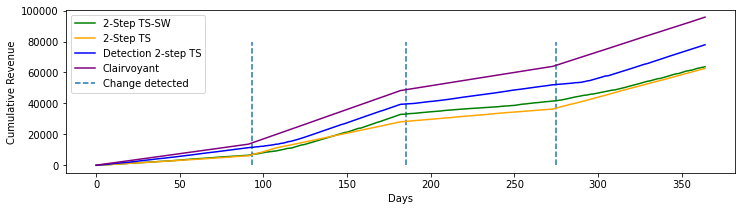

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,3))
plt.plot(np.cumsum(ts_sw_rewards_per_day), color='green', label='2-Step TS-SW')
plt.plot(np.cumsum(ts_rewards_per_day), color='orange', label='2-Step TS')
plt.plot(np.cumsum(detection_ts_rewards_per_day), color='blue', label='Detection 2-step TS')
plt.plot(np.cumsum(c_rewards_per_day), color='purple', label='Clairvoyant')

plt.vlines(np.array(phase_changes), 0, 80000, linestyles='dashed', label='Change detected')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Cumulative Revenue')

Text(0, 0.5, 'Revenue')

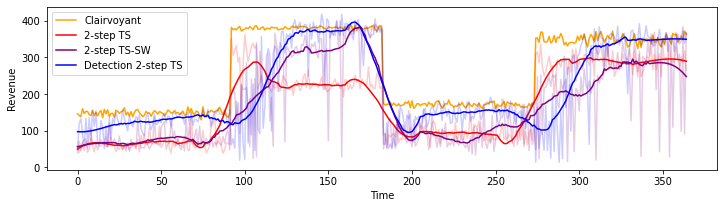

In [22]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

plt.figure(figsize=(12,3))
plt.plot(c_rewards_per_day, color='orange',label='Clairvoyant')
plt.plot(ts_rewards_per_day, color='red', alpha=0.2)
plt.plot(savgol_filter(ts_rewards_per_day, 45, 3), color='red', label='2-step TS')
plt.plot(ts_sw_rewards_per_day, color='purple', alpha=0.2)
plt.plot(savgol_filter(ts_sw_rewards_per_day, 45, 3), color='purple', label='2-step TS-SW')
plt.plot(detection_ts_rewards_per_day, color='blue', alpha=0.2)
plt.plot(savgol_filter(detection_ts_rewards_per_day, 45, 3), color='blue',label='Detection 2-step TS')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Revenue')

Text(0, 0.5, 'Regret')

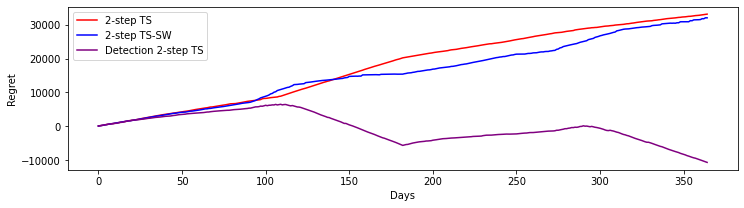

In [23]:
plt.figure(figsize=(12,3))
plt.plot(np.cumsum(np.array(c_rewards_per_day) - np.array(ts_rewards_per_day)), color='red', label='2-step TS')
plt.plot(np.cumsum(np.array(c_rewards_per_day) - np.array(ts_sw_rewards_per_day)), color='blue', label='2-step TS-SW')
plt.plot(np.cumsum(np.array(c_rewards_per_class_per_day) - np.array(detection_ts_rewards_per_day)), color='purple', label='Detection 2-step TS')


plt.legend()
plt.xlabel('Days')
plt.ylabel('Regret')